# Variational Inference and SGHMC

The purpose of this notebook is to compare Variational Inference (VI) and Stochastic Gradient Hamiltonian Monte Carlo (SGHMC) is the MNIST Bayesian neural network (BNN) setting.

As a fair comparison we allow (VI) 50 epochs to learn the variational parameters of the BNN, we also give SGHMC 50 burn-in epochs so that it has hopefully converged to the posterior distribution by this point (or at least found some good parameters). We then sample 80000 samples from the variational posterior and we (approximately) sample 80000 parameters from the true posterior using SGHMC.

We the compare the two sample sets using a 50000/10000 train/validation split.

In [1]:
import sys
sys.path.append("..")

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import seaborn as sns # conda install seaborn
import pandas as pd # ^^ this will automatically install pandas

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist

from kernel.sghmc import SGHMC

from pyro.infer import SVI, Trace_ELBO, RenyiELBO
from pyro.optim import SGD, Adam, ClippedAdam

pyro.set_rng_seed(101)

In [2]:
# Simple dataset wrapper class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

### Hyperparams

In [3]:
BATCH_SIZE = 500
NUM_EPOCHS = 50
WARMUP_EPOCHS = 50
HIDDEN_SIZE = 100

### Download MNIST and setup datasets / dataloaders

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

test_dataset = datasets.MNIST('./data', train=False, download=True)

nvalid = 10000

perm = torch.arange(len(train_dataset))
train_idx = perm[nvalid:]
val_idx = perm[:nvalid]
    
mean = 0.1307
std = 0.3081

# scale and normalise the datasets
X_train = (train_dataset.data[train_idx] / 255.0 - mean) / std
Y_train = train_dataset.targets[train_idx]

X_val = (train_dataset.data[val_idx] / 255.0 - mean) / std
Y_val = train_dataset.targets[val_idx]

X_test = (test_dataset.data / 255.0 - mean) / std
Y_test = test_dataset.targets

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)
test_dataset = Dataset(X_test, Y_test)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Define the Bayesian neural network  model

In [5]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class BNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, hidden_size, output_size, prec=1.):
        super().__init__()
        # prec is a kwarg that should only used by SGD to set the regularization strength 
        # recall that a Guassian prior over the weights is equivalent to L2 norm regularization in the non-Bayes setting
        
        # TODO add gamma priors to precision terms
        self.fc1 = PyroLinear(input_size, hidden_size)
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size, input_size]).to_event(2))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size]).to_event(1))
        
        self.fc2 = PyroLinear(hidden_size, output_size)
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size, hidden_size]).to_event(2))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size]).to_event(1))
        
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)

### Run VI

We run VI using the RenyiELBO to get a tight variational bound, we use the ClippedAdam optimizer which implements weight decay, gradient clipping, and learning rate decay.

We run this for 50 epochs but typically the validation loss diverges and so we stop early if the validation loss ever decreases.

In [6]:
pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10)
guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)

svi = SVI(model=bnn, 
          guide=guide, 
          optim=ClippedAdam({"lr": 1e-3, "weight_decay": 1e-3, "clip_norm": 1.0}), 
          loss=RenyiELBO(alpha=0.01, num_particles=2))

num_epochs = WARMUP_EPOCHS
epoch = 0

normalizer = len(train_loader.dataset)

test_acc = [0.0]

while epoch < num_epochs:
    losses = []
    for imgs, labels in train_loader:
        total_loss = svi.step(imgs, labels)
        loss = total_loss / normalizer
        losses += [loss]
        
    epoch += 1
        
    print('Epoch {} avg loss {:.4f}'.format(epoch, np.mean(losses)))
    
    predictive = pyro.infer.Predictive(model=bnn, guide=guide, num_samples=100)

    with torch.no_grad():
        total = 0
        correct = 0
        for imgs, labels in val_loader:
            out = predictive(imgs)
            pred = out['obs'].mode(0)[0]
            total += labels.shape[0]
            correct += int((pred == labels).sum())

        print("test accuracy:",correct/ total)
        
        if (correct / total) < test_acc[-1]:
            break
        else:
            test_acc.append(correct/total)
            continue
        

Epoch 1 avg loss 2.9783
test accuracy: 0.7882
Epoch 2 avg loss 2.7689
test accuracy: 0.8629
Epoch 3 avg loss 2.6098
test accuracy: 0.8945
Epoch 4 avg loss 2.4557
test accuracy: 0.9096
Epoch 5 avg loss 2.3043
test accuracy: 0.9235
Epoch 6 avg loss 2.1589
test accuracy: 0.9255
Epoch 7 avg loss 2.0173
test accuracy: 0.9315
Epoch 8 avg loss 1.8805
test accuracy: 0.934
Epoch 9 avg loss 1.7484
test accuracy: 0.9344
Epoch 10 avg loss 1.6218
test accuracy: 0.9366
Epoch 11 avg loss 1.5006
test accuracy: 0.9345


### Sample from the variational posterior

We draw 80000 samples (100 at a time) from the variational posterior and record the validation error and accuracy using Bayesian averaging.

In [7]:
# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

vi_test_errs = []

for epoch in range(1, 1+NUM_EPOCHS):
    predictive = pyro.infer.Predictive(model=bnn, guide=guide, num_samples=100)
    start = time.time()
    
    with torch.no_grad():
        epoch_predictive = None
        for x, y in val_loader:
            if epoch_predictive is None:
                epoch_predictive = predictive(x)['obs'].to(torch.int64)
            else:
                epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
                    
        for sample in epoch_predictive:
            predictive_one_hot = F.one_hot(sample, num_classes=10)
            full_predictive = full_predictive + predictive_one_hot
                
        full_y_hat = torch.argmax(full_predictive, dim=1)
        total = Y_val.shape[0]
        correct = int((full_y_hat == Y_val).sum())
            
    end = time.time()
        
    vi_test_errs.append(1.0 - correct/total)

    print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch, NUM_EPOCHS, correct/total, end - start))

Epoch [1/50] test accuracy: 0.9351 time: 13.99
Epoch [2/50] test accuracy: 0.9381 time: 14.25
Epoch [3/50] test accuracy: 0.9375 time: 14.26
Epoch [4/50] test accuracy: 0.9377 time: 13.64
Epoch [5/50] test accuracy: 0.9375 time: 14.33
Epoch [6/50] test accuracy: 0.9369 time: 13.68
Epoch [7/50] test accuracy: 0.9367 time: 14.10
Epoch [8/50] test accuracy: 0.9369 time: 14.20
Epoch [9/50] test accuracy: 0.9368 time: 14.02
Epoch [10/50] test accuracy: 0.9366 time: 13.90
Epoch [11/50] test accuracy: 0.9367 time: 14.28
Epoch [12/50] test accuracy: 0.9366 time: 14.31
Epoch [13/50] test accuracy: 0.9365 time: 14.38
Epoch [14/50] test accuracy: 0.9366 time: 14.34
Epoch [15/50] test accuracy: 0.9365 time: 13.96
Epoch [16/50] test accuracy: 0.9367 time: 14.78
Epoch [17/50] test accuracy: 0.9365 time: 14.15
Epoch [18/50] test accuracy: 0.9366 time: 14.13
Epoch [19/50] test accuracy: 0.9365 time: 14.82
Epoch [20/50] test accuracy: 0.9365 time: 14.87
Epoch [21/50] test accuracy: 0.9366 time: 15.50
E

### Run SGHMC 

We run SGHMC to sample approximately from the posterior distribution. First we need to redefine the dataset SGHMC seems to work better with scaled values in the range [0.0, 1.0] rather than normalised values.

In [8]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

test_dataset = datasets.MNIST('./data', train=False, download=True)

nvalid = 10000

perm = torch.arange(len(train_dataset))
train_idx = perm[nvalid:]
val_idx = perm[:nvalid]

# scale the datasets
X_train = train_dataset.data[train_idx] / 255.0
Y_train = train_dataset.targets[train_idx]

X_val = train_dataset.data[val_idx] / 255.0 
Y_val = train_dataset.targets[val_idx]

X_test = test_dataset.data / 255.0
Y_test = test_dataset.targets

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)
test_dataset = Dataset(X_test, Y_test)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
LR = 8e-6
MOMENTUM_DECAY = 0.1
RESAMPLE_EVERY_N = 100
NUM_STEPS = 1

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sghmc_test_errs = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int64)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        sghmc_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.64it/s, lr=8.00e-06]


Epoch [0/50] test accuracy: 0.9413 time: 4.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.89it/s, lr=8.00e-06]


Epoch [1/50] test accuracy: 0.9418 time: 4.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.20it/s, lr=8.00e-06]


Epoch [2/50] test accuracy: 0.9420 time: 4.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.17it/s, lr=8.00e-06]


Epoch [3/50] test accuracy: 0.9415 time: 4.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.23it/s, lr=8.00e-06]


Epoch [4/50] test accuracy: 0.9412 time: 4.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.28it/s, lr=8.00e-06]


Epoch [5/50] test accuracy: 0.9418 time: 4.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.79it/s, lr=8.00e-06]


Epoch [6/50] test accuracy: 0.9416 time: 4.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.68it/s, lr=8.00e-06]


Epoch [7/50] test accuracy: 0.9416 time: 4.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.57it/s, lr=8.00e-06]


Epoch [8/50] test accuracy: 0.9419 time: 4.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.41it/s, lr=8.00e-06]


Epoch [9/50] test accuracy: 0.9420 time: 5.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.21it/s, lr=8.00e-06]


Epoch [10/50] test accuracy: 0.9417 time: 5.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.95it/s, lr=8.00e-06]


Epoch [11/50] test accuracy: 0.9422 time: 5.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.54it/s, lr=8.00e-06]


Epoch [12/50] test accuracy: 0.9421 time: 4.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.57it/s, lr=8.00e-06]


Epoch [13/50] test accuracy: 0.9421 time: 4.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.28it/s, lr=8.00e-06]


Epoch [14/50] test accuracy: 0.9422 time: 4.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.03it/s, lr=8.00e-06]


Epoch [15/50] test accuracy: 0.9423 time: 4.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.34it/s, lr=8.00e-06]


Epoch [16/50] test accuracy: 0.9422 time: 4.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.14it/s, lr=8.00e-06]


Epoch [17/50] test accuracy: 0.9422 time: 4.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.26it/s, lr=8.00e-06]


Epoch [18/50] test accuracy: 0.9422 time: 4.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.43it/s, lr=8.00e-06]


Epoch [19/50] test accuracy: 0.9424 time: 4.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.80it/s, lr=8.00e-06]


Epoch [20/50] test accuracy: 0.9423 time: 4.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.89it/s, lr=8.00e-06]


Epoch [21/50] test accuracy: 0.9424 time: 4.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.19it/s, lr=8.00e-06]


Epoch [22/50] test accuracy: 0.9420 time: 4.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.31it/s, lr=8.00e-06]


Epoch [23/50] test accuracy: 0.9422 time: 4.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.04it/s, lr=8.00e-06]


Epoch [24/50] test accuracy: 0.9427 time: 4.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.83it/s, lr=8.00e-06]


Epoch [25/50] test accuracy: 0.9428 time: 5.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.98it/s, lr=8.00e-06]


Epoch [26/50] test accuracy: 0.9428 time: 4.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.28it/s, lr=8.00e-06]


Epoch [27/50] test accuracy: 0.9432 time: 4.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.77it/s, lr=8.00e-06]


Epoch [28/50] test accuracy: 0.9433 time: 4.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.41it/s, lr=8.00e-06]


Epoch [29/50] test accuracy: 0.9434 time: 4.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.78it/s, lr=8.00e-06]


Epoch [30/50] test accuracy: 0.9434 time: 4.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.88it/s, lr=8.00e-06]


Epoch [31/50] test accuracy: 0.9435 time: 4.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.34it/s, lr=8.00e-06]


Epoch [32/50] test accuracy: 0.9436 time: 4.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.95it/s, lr=8.00e-06]


Epoch [33/50] test accuracy: 0.9436 time: 4.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.10it/s, lr=8.00e-06]


Epoch [34/50] test accuracy: 0.9435 time: 4.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.05it/s, lr=8.00e-06]


Epoch [35/50] test accuracy: 0.9435 time: 4.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.13it/s, lr=8.00e-06]


Epoch [36/50] test accuracy: 0.9435 time: 4.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.49it/s, lr=8.00e-06]


Epoch [37/50] test accuracy: 0.9442 time: 4.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.61it/s, lr=8.00e-06]


Epoch [38/50] test accuracy: 0.9444 time: 4.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.10it/s, lr=8.00e-06]


Epoch [39/50] test accuracy: 0.9444 time: 4.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.15it/s, lr=8.00e-06]


Epoch [40/50] test accuracy: 0.9441 time: 4.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.29it/s, lr=8.00e-06]


Epoch [41/50] test accuracy: 0.9441 time: 4.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.74it/s, lr=8.00e-06]


Epoch [42/50] test accuracy: 0.9442 time: 5.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.26it/s, lr=8.00e-06]


Epoch [43/50] test accuracy: 0.9441 time: 5.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.77it/s, lr=8.00e-06]


Epoch [44/50] test accuracy: 0.9445 time: 5.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.26it/s, lr=8.00e-06]


Epoch [45/50] test accuracy: 0.9445 time: 5.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.24it/s, lr=8.00e-06]


Epoch [46/50] test accuracy: 0.9448 time: 5.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.24it/s, lr=8.00e-06]


Epoch [47/50] test accuracy: 0.9448 time: 4.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.55it/s, lr=8.00e-06]


Epoch [48/50] test accuracy: 0.9447 time: 4.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.59it/s, lr=8.00e-06]


Epoch [49/50] test accuracy: 0.9449 time: 5.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.19it/s, lr=8.00e-06]


Epoch [50/50] test accuracy: 0.9453 time: 5.05


### Plot VI against SGHMC

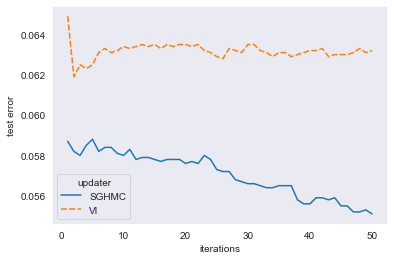

In [10]:
sns.set_style("dark")
    
sghmc_test_errs = np.array(sghmc_test_errs)
vi_test_errs = np.array(vi_test_errs)

err_dict = {'SGHMC' : sghmc_test_errs, 'VI' : vi_test_errs}
x = np.arange(1, NUM_EPOCHS+1)
lst = []
for i in range(len(x)):
    for updater in err_dict.keys():
        lst.append([x[i], updater, err_dict[updater][i]])

df = pd.DataFrame(lst, columns=['iterations', 'updater','test error'])
sns.lineplot(data=df.pivot("iterations", "updater", "test error"))
plt.ylabel("test error")
plt.show() #dpi=300